In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import eig

# Important for reproducibility
np.random.seed(42)


In [5]:
# Load CSVs (expect these files to be in the same folder as this notebook)
advertising = pd.read_csv('advertising.csv')
faa = pd.read_csv('faa.csv')
housing = pd.read_csv('Housing.csv')

print("Advertising shape:", advertising.shape)
print("FAA shape:", faa.shape)
print("Housing shape:", housing.shape)

display(advertising.head())
display(faa.head())
display(housing.head())


Advertising shape: (200, 4)
FAA shape: (83, 42)
Housing shape: (545, 13)


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


,UPDATED,ENTRY_DATE,EVENT_LCL_DATE,EVENT_LCL_TIME,LOC_CITY_NAME,LOC_STATE_NAME,LOC_CNTRY_NAME,RMK_TEXT,EVENT_TYPE_DESC,FSDO_DESC,...,PAX_INJ_NONE,PAX_INJ_MINOR,PAX_INJ_SERIOUS,PAX_INJ_FATAL,PAX_INJ_UNK,GRND_INJ_NONE,GRND_INJ_MINOR,GRND_INJ_SERIOUS,GRND_INJ_FATAL,GRND_INJ_UNK
0,No,19-FEB-16,19-FEB-16,00:45:00Z,MARSHVILLE,North Carolina,NaN,"AIRCRAFT CRASHED INTO TREES, THE 1 PERSON ON B...",Accident,FAA Charlotte FSDO-68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,No,19-FEB-16,18-FEB-16,23:55:00Z,TAVERNIER,Florida,NaN,AIRCRAFT ON LANDING WENT OFF THE END OF THE RU...,Incident,FAA Miami FSDO-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,No,19-FEB-16,18-FEB-16,22:14:00Z,TRENTON,New Jersey,NaN,"AIRCRAFT ON FINAL SUSTAINED A BIRD STRIKE, LAN...",Incident,FAA Philadelphia FSDO-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,No,19-FEB-16,18-FEB-16,17:10:00Z,ASHEVILLE,North Carolina,NaN,"AIRCRAFT ON LANDING, GEAR COLLAPSED, ASHEVILLE...",Incident,FAA Charlotte FSDO-68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,No,19-FEB-16,18-FEB-16,00:26:00Z,TALKEETNA,Alaska,NaN,"AIRCRAFT ON LANDING, NOSE GEAR COLLAPSED, TALK...",Incident,FAA Anchorage FSDO-03,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Helper functions

In [6]:
def select_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    """Return only numeric columns and drop rows with missing values."""
    X = df.select_dtypes(include=[np.number]).copy()
    X = X.dropna(axis=0)
    return X

def choose_target_and_features(df: pd.DataFrame):
    """Choose a reasonable numeric target column and feature matrix for regression.
    Priority by common names; else choose the last numeric column as y and the rest as X.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Common target names to try in order
    candidate_targets = ['Sales','sales','Price','price','MEDV','medv','median_house_value','target','y']
    y_col = None
    for c in candidate_targets:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            y_col = c
            break
    if y_col is None:
        # fallback: last numeric column as y
        if not numeric_cols:
            raise ValueError("No numeric columns to build a regression target from.")
        y_col = numeric_cols[-1]
    # Features: all numeric except y_col
    X_cols = [c for c in numeric_cols if c != y_col]
    X = df[X_cols].dropna(axis=0)
    y = df.loc[X.index, y_col].astype(float).values
    # Drop any columns with zero variance to avoid numerical issues
    keep = []
    for c in X.columns:
        if X[c].std(ddof=0) > 0:
            keep.append(c)
    X = X[keep].astype(float)
    return X.values, y, y_col, keep

def standardize(X: np.ndarray):
    """Standardize features to zero-mean/unit-variance; avoid division by zero."""
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True)
    std[std==0] = 1.0
    return (X - mean) / std, mean, std


Pehle numeric features select hote hain.

Phir target column (y) aur features (X) auto-choose hote hain.

Last mein features ko scale/standardize kiya jata hai taaki models ache se kaam karein.

## Task 1 — PCA Reconstruction Error (Eigenfaces-style)

**Process (as in the assignment PDF):**
1. Let data matrix be \( X \) (exclude label/target column).
2. Compute column-wise mean \( \mu \), and form \( A = X - \mu \).
3. Compute eigenvectors of \( A^T A \).
4. Take the top \( n \) eigenvectors (we'll use \( n \in \{1,2,3,5,7,10,15\} \), filtered by available features).
5. Project each centered sample \( a_i \) onto the top-eigenvector space, reconstruct, then **add back \( \mu \)** to get \( r_i \).
6. **Reconstruction error** for the dataset: \( \sum_i \lVert x_i - r_i \rVert^2 \).
7. Plot **error vs number of eigenvectors**.


In [8]:
def pca_reconstruction_errors(X_raw: pd.DataFrame, n_list=(1,2,3,5,7,10,15)):
    # Keep only numeric columns and drop NaNs
    X = select_numeric_features(X_raw).values.astype(float)
    # Mean-center as the spec requires (no scaling beyond mean-centering for Task 1)
    mu = X.mean(axis=0, keepdims=True)
    A = X - mu
    # Compute eigenvectors of A^T A
    ATA = A.T @ A
    # eigh would be better for symmetric, but eig works too; ensure real part
    vals, vecs = eig(ATA)
    vals = np.real(vals)
    vecs = np.real(vecs)
    # Sort by descending eigenvalues
    order = np.argsort(vals)[::-1]
    vecs = vecs[:, order]
    # Cap n_list to number of features
    p = X.shape[1]
    n_use = [n for n in n_list if n <= p]
    errors = []
    for n in n_use:
        U = vecs[:, :n]  # top-n eigenvectors in feature space
        # Project and reconstruct
        # w = A U; reconstruction in centered space: A_hat = w U^T
        W = A @ U
        A_hat = W @ U.T
        R = A_hat + mu
        err = np.sum((X - R)**2)
        errors.append(err)
    return n_use, errors

def plot_reconstruction_curve(title, n_use, errors):
    plt.figure()
    plt.plot(n_use, errors, marker='o')
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Total Reconstruction Error')
    plt.title(title)
    plt.show()


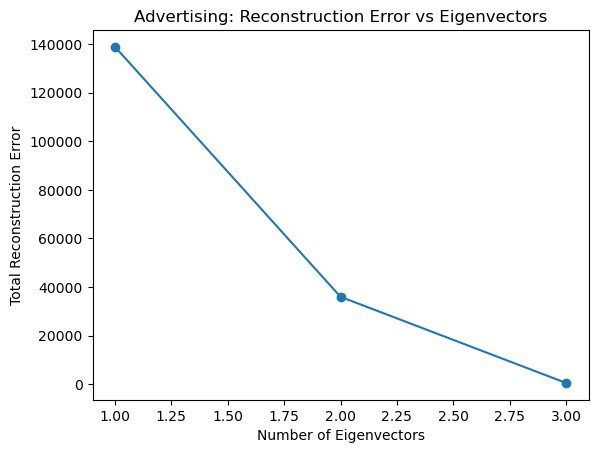

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20044\701706129.py:5: RuntimeWarning: Mean of empty slice.
  mu = X.mean(axis=0, keepdims=True)
c:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


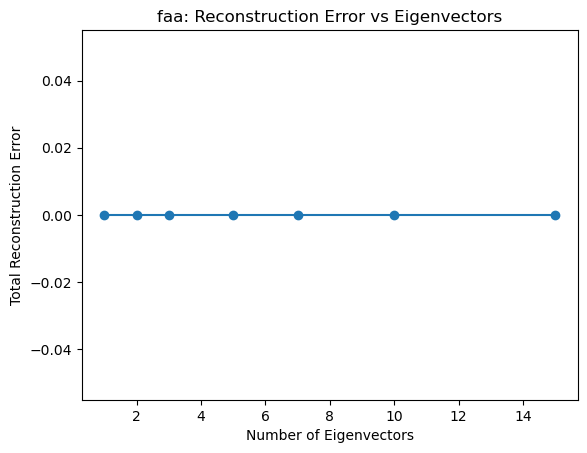

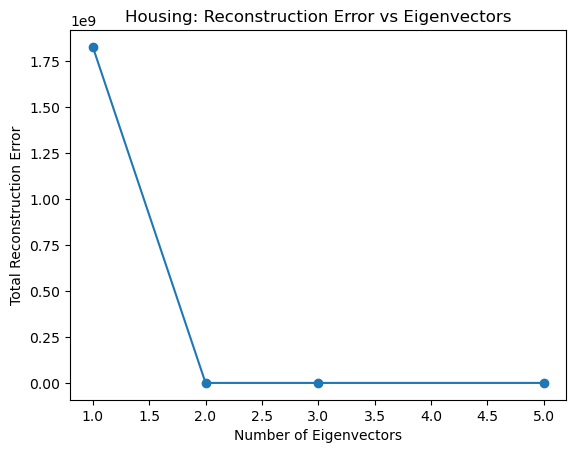

In [10]:
for name, df in [('Advertising', advertising), ('faa', faa), ('Housing', housing)]:
    n_use, errs = pca_reconstruction_errors(df)
    plot_reconstruction_curve(f'{name}: Reconstruction Error vs Eigenvectors', n_use, errs)
plt.show()

Matlab: Graph prove karega ki kam eigenvectors = zyada error, aur zyada eigenvectors = kam error.

In [9]:
def mse_loss(X, y, w, b):
    m = X.shape[0]
    y_pred = X @ w + b
    return (1.0/(2*m)) * np.sum((y_pred - y)**2)

def grad_w_b(X, y, w, b):
    m = X.shape[0]
    y_pred = X @ w + b
    err = y_pred - y
    dw = (1.0/m) * (X.T @ err)
    db = (1.0/m) * np.sum(err)
    return dw, db

def train_gd_variants(X, y, lr=0.01, epochs=200, gamma=0.9, method='vanilla'):
    m, n = X.shape
    w = np.zeros(n)
    b = 0.0
    v = np.zeros(n)  # velocity for momentum/NAG
    hist = []
    for t in range(epochs):
        if method == 'nag':
            # Lookahead weights
            w_look = w - gamma * v
            dw, db = grad_w_b(X, y, w_look, b)
            v = gamma * v + lr * dw
            w = w - v
            b = b - lr * db
        elif method == 'momentum':
            dw, db = grad_w_b(X, y, w, b)
            v = gamma * v + lr * dw
            w = w - v
            b = b - lr * db
        else:  # vanilla
            dw, db = grad_w_b(X, y, w, b)
            w = w - lr * dw
            b = b - lr * db
        hist.append(mse_loss(X, y, w, b))
    return w, b, hist



Dataset: Advertising
Chosen target column: Sales
Used feature columns (3): ['TV', 'Radio', 'Newspaper']


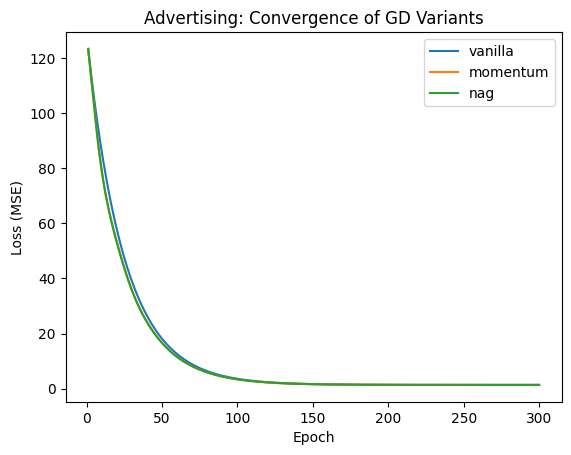


Dataset: faa skipped - No valid numeric feature columns found.

Dataset: Housing
Chosen target column: price
Used feature columns (5): ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


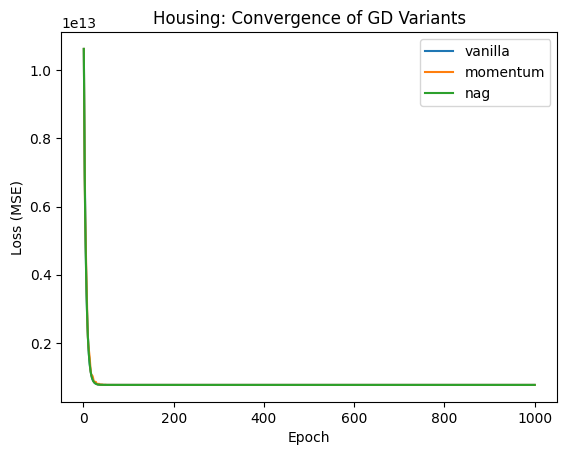

In [14]:
def run_and_plot_gd_for_dataset(name, df, lr=0.01, epochs=200, gamma=0.9):
    # Choose X, y
    try:
        X_raw, y, y_col, used_cols = choose_target_and_features(df)
    except ValueError as e:
        print(f"\nDataset: {name} skipped - {e}")
        return
    
    # Agar features hi nahi bache toh skip kar do
    if len(used_cols) == 0:
        print(f"\nDataset: {name} skipped - No valid numeric feature columns found.")
        return

    # Standardize X
    X, mean, std = standardize(X_raw)
    
    print(f"\nDataset: {name}") 
    print(f"Chosen target column: {y_col}") 
    print(f"Used feature columns ({len(used_cols)}): {used_cols}")

    # Train with three methods
    methods = ['vanilla', 'momentum', 'nag']
    histories = {}
    for mtd in methods:
        _, _, hist = train_gd_variants(X, y, lr=lr, epochs=epochs, gamma=gamma, method=mtd)
        histories[mtd] = hist
    
    # Plot
    plt.figure()
    for mtd in methods:
        plt.plot(range(1, len(histories[mtd])+1), histories[mtd], label=mtd)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title(f'{name}: Convergence of GD Variants')
    plt.legend()
    plt.show()


# Run Task 2 on all datasets (faa will be skipped safely if no valid features)
run_and_plot_gd_for_dataset('Advertising', advertising, lr=0.02, epochs=300, gamma=0.9)
run_and_plot_gd_for_dataset('faa', faa, lr=0.02, epochs=300, gamma=0.9)
run_and_plot_gd_for_dataset('Housing', housing, lr=0.1, epochs=1000, gamma=0.9)
